In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [3]:
# Load the data
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']
ais = pd.read_csv('rotterdam_hamburg.arff', names = names, skiprows = 27, parse_dates = True,
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [4]:
ais.head()

TripID       MMSI  StartLatitude  StartLongitude          StartTime  \
0  21109  210481000          51.94            4.05  '2016-1-21 04:32'   
1  21109  210481000          51.94            4.05  '2016-1-21 04:32'   
2  21109  210481000          51.94            4.05  '2016-1-21 04:32'   
3  21109  210481000          51.94            4.05  '2016-1-21 04:32'   
4  21109  210481000          51.94            4.05  '2016-1-21 04:32'   

   EndLatitude  EndLongitude            EndTime  StartPort  EndPort  \
0        53.53          9.91  '2016-1-22 06:04'  ROTTERDAM  HAMBURG   
1        53.53          9.91  '2016-1-22 06:04'  ROTTERDAM  HAMBURG   
2        53.53          9.91  '2016-1-22 06:04'  ROTTERDAM  HAMBURG   
3        53.53          9.91  '2016-1-22 06:04'  ROTTERDAM  HAMBURG   
4        53.53          9.91  '2016-1-22 06:04'  ROTTERDAM  HAMBURG   

            ...            Draught Latitude Longitude   SOG   COG    TH  \
0           ...              10.64    53.95      7.82  14.7  81.0  80.0   
1           ...              10.64    53.95      7.83  14.7  80.0  80.0   
2           ...              10.64    53.95      7.83  14.7  81.0  80.0   
3           ...              10.64    53.95      7.84  14.7  80.0  80.0   
4           ...              10.64    53.95      7.85  14.7  81.0  80.0   

   Destination             Name  Callsign              AisSourcen  
0      HAMBURG  CMA.CGM.SAMBHAR     5BND2  H7001.DAIS1.81b.71.71a  
1      HAMBURG  CMA.CGM.SAMBHAR     5BND2  H7001.DAIS1.81b.71.71a  
2      HAMBURG  CMA.CGM.SAMBHAR     5BND2  H7001.DAIS1.81b.71.71a  
3      HAMBURG  CMA.CGM.SAMBHAR     5BND2  H7001.DAIS1.81b.71.71a  
4      HAMBURG  CMA.CGM.SAMBHAR     5BND2  H7001.DAIS1.81b.71.71a  

[5 rows x 25 columns]

In [5]:
ais_nan = ais

In [6]:
# Convert time columns to correct dtype
ais_nan['StartTime'] = pd.to_datetime(ais_nan['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['EndTime'] = pd.to_datetime(ais_nan['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['time'] = pd.to_datetime(ais_nan['time'], format = '\'%Y-%m-%d %H:%M\'')

In [7]:
# Convert all headings that are 511 (>= 360) to NaN
ais_nan.loc[ais_nan['TH'] >= 360, 'TH'] = np.nan

In [8]:
# Convert courses >= 360 to NaN
ais_nan.loc[ais_nan['COG'] >= 360, 'COG'] = np.nan

In [9]:
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais_nan.loc[(ais_nan['shiptype'] == '0') | (ais_nan['shiptype'] == '159'), 'shiptype'] = np.nan

In [10]:
# Set invalid lengths (0 or > 400) to NaN
ais_nan.loc[(ais_nan['Length'] <= 0) | (ais_nan['Length'] > 400), 'Length'] = np.nan

In [11]:
# Set invalid lengths (0 or > 59) to NaN
ais_nan.loc[(ais_nan['Breadth'] <= 0) | (ais_nan['Breadth'] > 59), 'Breadth'] = np.nan

In [12]:
# Set speeds that are unrealisticly high to NaN
ais_nan.loc[ais_nan['SOG'] > 25.6, 'SOG'] = np.nan

In [13]:
ais_dropped = ais_nan.drop(['AisSourcen', 'ID', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)

In [14]:
ais_dropped.head()

TripID  StartLatitude  StartLongitude           StartTime  EndLatitude  \
0  21109          51.94            4.05 2016-01-21 04:32:00        53.53   
1  21109          51.94            4.05 2016-01-21 04:32:00        53.53   
2  21109          51.94            4.05 2016-01-21 04:32:00        53.53   
3  21109          51.94            4.05 2016-01-21 04:32:00        53.53   
4  21109          51.94            4.05 2016-01-21 04:32:00        53.53   

   EndLongitude             EndTime                time  Length  Breadth  \
0          9.91 2016-01-22 06:04:00 2016-01-21 22:04:00   269.0     32.0   
1          9.91 2016-01-22 06:04:00 2016-01-21 22:05:00   269.0     32.0   
2          9.91 2016-01-22 06:04:00 2016-01-21 22:06:00   269.0     32.0   
3          9.91 2016-01-22 06:04:00 2016-01-21 22:07:00   269.0     32.0   
4          9.91 2016-01-22 06:04:00 2016-01-21 22:08:00   269.0     32.0   

   Draught  Latitude  Longitude   SOG   COG    TH Destination Callsign  
0    10.64     53.95       7.82  14.7  81.0  80.0     HAMBURG    5BND2  
1    10.64     53.95       7.83  14.7  80.0  80.0     HAMBURG    5BND2  
2    10.64     53.95       7.83  14.7  81.0  80.0     HAMBURG    5BND2  
3    10.64     53.95       7.84  14.7  80.0  80.0     HAMBURG    5BND2  
4    10.64     53.95       7.85  14.7  81.0  80.0     HAMBURG    5BND2

Text(0.5,1,u'All Positions Before Filtering')

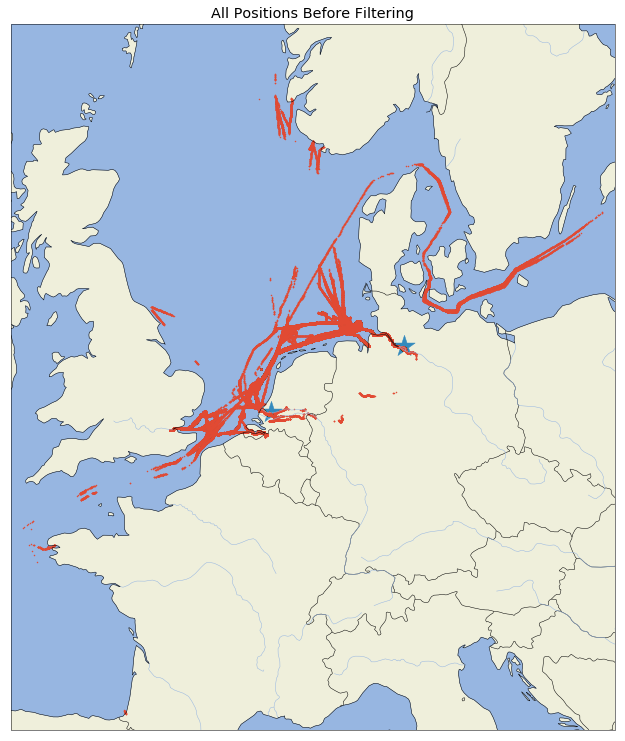

In [15]:
# Plot all positions in the data before any filters are applied
aismap.plot_to_map(size = (13, 13), longitude = ais_dropped['Longitude'], latitude = ais_dropped['Latitude'])
plt.title("All Positions Before Filtering")

Text(0.5,1,u'Start Positions Before Filtering')

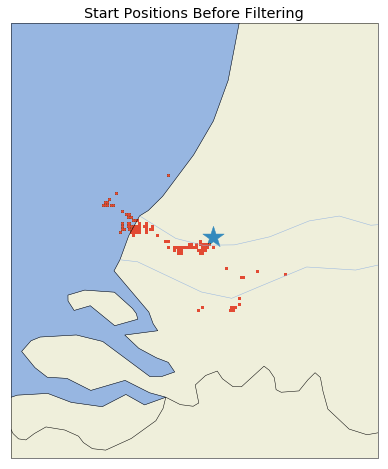

In [16]:
# Plot start positions before any filtering to map
aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['StartLongitude'], latitude = ais_dropped['StartLatitude'])
plt.title("Start Positions Before Filtering")

Text(0.5,1,u'End Positions Before Filtering')

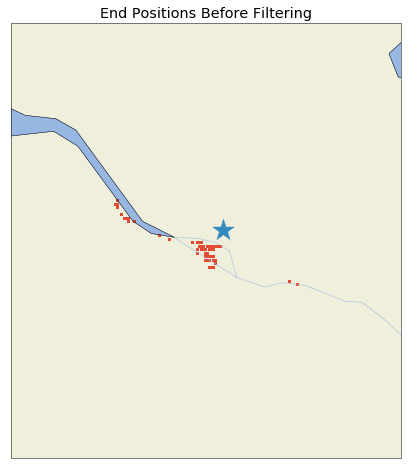

In [17]:
# Plot end positions before any filtering to map
aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['EndLongitude'], latitude = ais_dropped['EndLatitude'])
plt.title("End Positions Before Filtering")

In [18]:
# Get rid of trips that leave our zone (2.45 - 10.66 / 51.49 - 55.06)

outside_long_mask = (ais_dropped['Longitude'] < 2.45) | (ais_dropped['Longitude'] > 10.66)
outside_lat_mask = (ais_dropped['Latitude'] < 51.49) | (ais_dropped['Latitude'] > 55.06)

outside_rec_mask = outside_long_mask | outside_lat_mask

outside_trip_ids = ais_dropped['TripID'][outside_rec_mask].unique()
outside_trip_mask = ~ais_dropped['TripID'].isin(outside_trip_ids)
ais_zoned = ais_dropped[outside_trip_mask]

Text(0.5,1,u'All Positions After Filtering to Our Zone')

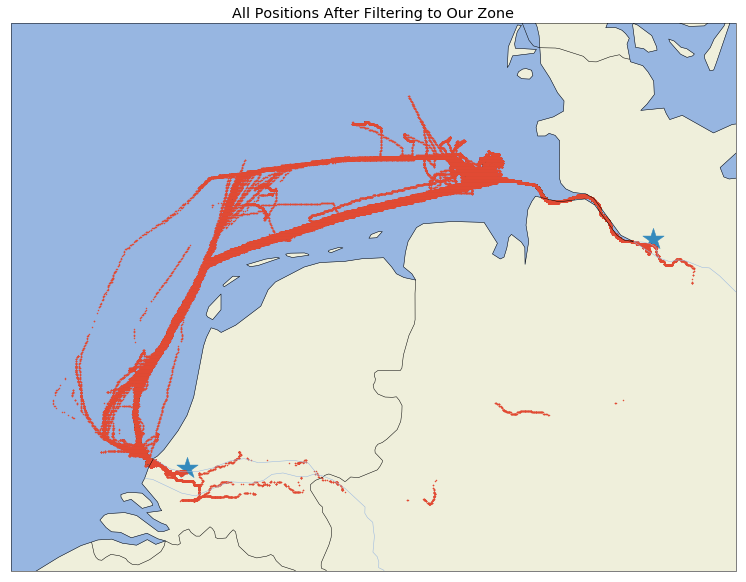

In [19]:
aismap.plot_to_map(size = (13, 13), longitude = ais_zoned['Longitude'], latitude = ais_zoned['Latitude'])
plt.title("All Positions After Filtering to Our Zone")

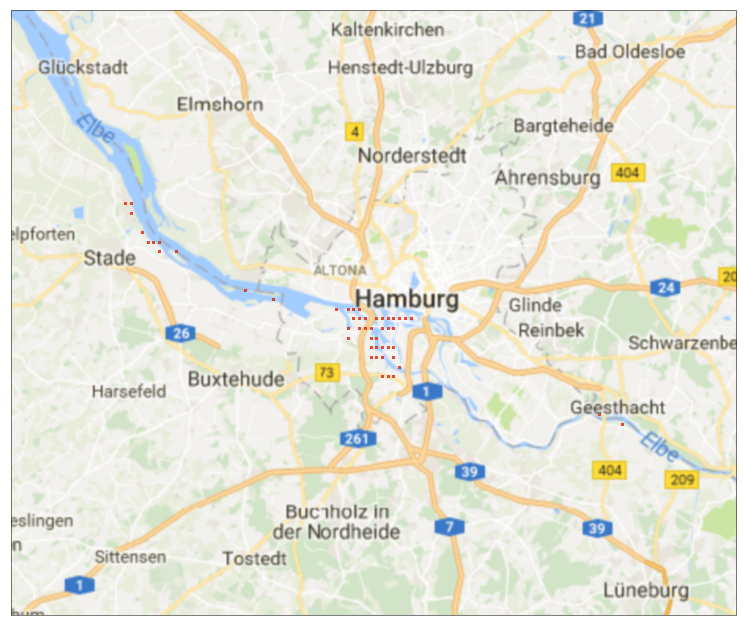

In [20]:
minlat = ais_zoned['EndLatitude'].min() - 0.2
maxlat = ais_zoned['EndLatitude'].max() + 0.2
minlong = ais_zoned['EndLongitude'].min() - 0.2
maxlong = ais_zoned['EndLongitude'].max() + 0.2

aismap.plot_google_map((minlong, maxlong, minlat, maxlat))
plt.scatter(x = ais_zoned['EndLongitude'], y = ais_zoned['EndLatitude'] , transform = ccrs.PlateCarree(), s = 1)

In [21]:
# Get times finish line is crossed, by trips that do cross it
finish_line_ts = ais_zoned[ais_zoned['Longitude'] > 9.81].groupby('TripID')['time'].min()

# Only keep trips that do cross the finish line
ais_ham_zoned = ais_zoned[ais_zoned['TripID'].isin(finish_line_ts.index)]

#Set EndTime to the time the ship first appears behind the finish line
for tripid in finish_line_ts.index :
    ais_ham_zoned.loc[ais_ham_zoned['TripID'] == tripid, 'EndTime'] = finish_line_ts.loc[tripid]

# Throw out all records after the finish line was crossed
ais_ham_zoned = ais_ham_zoned[ais_ham_zoned['time'] <= ais_ham_zoned['EndTime']]

/Users/jankaiser/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


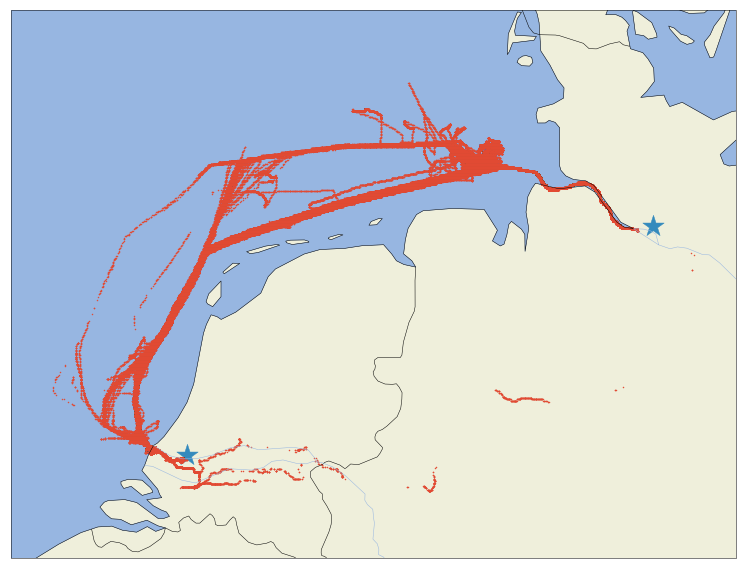

In [22]:
aismap.plot_to_map(size = (13, 13), longitude = ais_ham_zoned['Longitude'], latitude = ais_ham_zoned['Latitude'])

In [ ]:
ais_tts = ais_ham_zoned
ais_tts.is_copy = False   # Hack to silence SettingWithCopyWarning

# Add time for the entire trip to the data
ais_tts['TravelTime'] = ais_tts['EndTime'] - ais_tts['StartTime']
ais_tts['TravelTimeMins'] = ais_tts['TravelTime'].transform(lambda x : x.total_seconds() / 60)

# Add time remaining until arrival at destination
ais_tts['remainingTT'] = ais_tts['EndTime'] - ais_tts['time']
ais_tts['remainingMins'] = ais_tts['remainingTT'].transform(lambda x : x.total_seconds() / 60)

In [ ]:
aismap.plot_trips(ais_tts, 'TravelTime')

In [ ]:
travel_times = ais_tts.groupby('TripID')['TravelTime'].max()
travel_times = travel_times.transform(lambda x : x.total_seconds() // 3600)
travel_times.value_counts().sort_index().plot.bar(figsize = (25, 10))

In [ ]:
travel_times[travel_times < travel_times.quantile(.75)].value_counts().sort_index().plot.bar(figsize = (25, 10))

In [ ]:
# Only keep majority of shorter trips
ais_shortmaj = ais_tts[ais_tts['TravelTime'] < ais_tts['TravelTime'].quantile(.75)]
ais_shortmaj['TravelTime'].describe()

In [ ]:
#ais_shortmaj['Cur_Pos'] = list(zip(ais_shortmaj['Latitude'], ais_shortmaj['Longitude']))
#ais_shortmaj['End_Pos'] = list(zip(ais_shortmaj['EndLatitude'], ais_shortmaj['EndLongitude']))

In [ ]:
#ais_shortmaj['Distance'] =  ais_shortmaj.apply(lambda r: pandasVincenty(r), axis=1)
#ais_shortmaj.head()

In [ ]:
aismap.col_plot_to_map(size = (13, 13), longitude = ais_shortmaj['Longitude'], latitude = ais_shortmaj['Latitude'], col= ais_shortmaj['remainingMins'])

In [ ]:
# Get and plot the longest trip in the data set
longest_trip = ais_shortmaj[ais_shortmaj['TravelTime'] == ais_shortmaj['TravelTime'].max()]
longest_trip.head()

In [ ]:
aismap.col_plot_to_map(size = (13, 13), longitude = longest_trip['Longitude'], latitude = longest_trip['Latitude'], col = longest_trip['remainingMins'])
plt.title("Longest Trip in the Data Set")

In [ ]:
sns.pairplot(ais_shortmaj, x_vars = ['Latitude', 'Longitude'], y_vars = 'remainingMins', size = 7)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.grid_search import RandomizedSearchCV

import math

In [ ]:
X = ais_shortmaj[['Latitude', 'Longitude']]
y = ais_shortmaj['remainingTT']
y = y.transform(lambda x : x.total_seconds() / 60)

In [ ]:
lin = LinearRegression()
lin.fit(X_train, y_train)

lin_pred = lin.predict(X_test)
sqrt(metrics.mean_squared_error(y_test, lin_pred))

In [ ]:
knn = KNeighborsRegressor(n_neighbors = 100)
knn.fit(X_train, y_train)

In [ ]:
knn_pred = knn.predict(X_test)
sqrt(metrics.mean_squared_error(y_test, knn_pred))

In [ ]:
k_range = range(1, 30)
scores = []

for k in k_range :
    kknn = KNeighborsRegressor(n_neighbors = k)
    kknn.fit(X_train, y_train)
    kknn_pred = kknn.predict(X_test)
    scores.append(sqrt(metrics.mean_squared_error(y_test, kknn_pred)))

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(k_range, scores)